EXPLICACION UNO:
En esta primera parte se importan las librerías necesarias para el análisis. Se utiliza pandas para la manipulación de datos en forma de DataFrames, numpy para realizar operaciones numéricas y estadísticas, y seaborn junto con la función heatmap para la visualización gráfica de correlaciones. Después de importar las librerías, se carga el archivo Calificaciones.csv en un DataFrame llamado df. Una vez cargado, se imprime la dimensión de la base de datos mediante shape, lo que indica el número de filas y columnas disponibles. También se muestran los nombres de las columnas con columns, las primeras cinco observaciones con head(5) y los tipos de dato de cada variable usando dtypes.

In [187]:
import pandas as pd
import numpy as np
from seaborn import heatmap
import seaborn as sns

df=pd.read_csv("Calificaciones.csv")
print(df.shape)
print(df.columns)
print(df.head(5))
print(df.dtypes)

(395, 10)
Index(['Escuela', 'Sexo', 'Edad', 'HorasDeEstudio', 'Reprobadas', 'Internet',
       'Faltas', 'G1', 'G2', 'G3'],
      dtype='object')
  Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  G3
0      GP    F    18               2           0       no       6   5   6   6
1      GP    F    17               2           0      yes       4   5   5   6
2      GP    F    15               2           3      yes      10   7   8  10
3      GP    F    15               3           0      yes       2  15  14  15
4      GP    F    16               2           0       no       4   6  10  10
Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


EXPLICACION DOS:
Aquí se realiza la transformación de variables categóricas en variables dummy (0/1) para que puedan usarse en un modelo de regresión:

Con np.where(df.dtypes==object) se obtienen los índices de las columnas categóricas.

En un ciclo, se aplica pd.get_dummies() para convertir cada columna categórica en variables binarias.

Se concatenan al DataFrame (pd.concat) y luego se eliminan las columnas originales.

La variable HorasDeEstudio también se convierte a dummies manualmente (dummyHoras).
Con esto se asegura que todas las variables sean numéricas y adecuadas para el modelo.

In [188]:
import numpy as np
ind=np.where(df.dtypes==object)
for i in ind:
      dummy=pd.get_dummies(df.iloc[:,i],drop_first=True)
      df=pd.concat([df,dummy],axis=1)
df=df.drop(labels=df.columns[ind],axis=1)
dummyHoras = pd.get_dummies(df.HorasDeEstudio,drop_first = True)
df=pd.concat([df,dummyHoras],axis=1)
df=df.drop("HorasDeEstudio",axis=1)
df.head()

,Edad,Reprobadas,Faltas,G1,G2,G3,Escuela_MS,Sexo_M,Internet_yes,2,3,4
0,18,0,6,5,6,6,False,False,False,True,False,False
1,17,0,4,5,5,6,False,False,True,True,False,False
2,15,3,10,7,8,10,False,False,True,True,False,False
3,15,0,2,15,14,15,False,False,True,False,True,False
4,16,0,4,6,10,10,False,False,False,True,False,False


EXPLICACION TRES:Aquí se identifican y eliminan los valores atípicos de la variable Faltas mediante el método de Tukey con k=3. Primero se calculan los cuartiles Q1 y Q3 y, a partir de ellos, el rango intercuartílico (IQR). Con este valor se determinan los límites inferior y superior para definir qué registros se consideran extremos. Después, se utilizan condiciones lógicas con np.where para identificar a los estudiantes cuyas faltas se encuentran fuera de estos límites. Estas observaciones se imprimen para analizarlas y, posteriormente, se eliminan del DataFrame. Se considera que las faltas con valores atípicos deben eliminarse porque representan situaciones poco comunes, como estudiantes con un número excesivamente alto de inasistencias que no son representativos de la mayoría del grupo. Mantener estos valores podría distorsionar el ajuste del modelo de regresión y generar conclusiones sesgadas, por lo que resulta más adecuado retirarlos del análisis.

In [189]:
Q1=df.Faltas.quantile(0.25)
Q3=df.Faltas.quantile(0.75)
IQR=Q3-Q1
li=Q1-(3*IQR)
ls=Q3+(3*IQR)
out=np.where((df.Faltas<=li) | (df.Faltas>=ls))[0]
print(df.iloc[out,:])
df = df.drop(index=out)

     Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
74     16           0      54  11  12  11       False   False          True   
183    17           0      56   9   9   8       False   False          True   
276    18           0      75  10   9   9       False   False          True   
307    19           1      38   8   9   8       False    True          True   
315    19           1      40  13  11  11       False   False          True   

         2      3      4  
74    True  False  False  
183   True  False  False  
276   True  False  False  
307  False  False  False  
315  False   True  False  


EXPLICACON CUATRO:En este apartado se realiza un análisis de la correlación entre variables para identificar problemas de colinealidad, es decir, cuando dos o más variables están demasiado relacionadas entre sí y pueden aportar información redundante al modelo. 
Primero se calcula la matriz de correlación absoluta mediante np.corrcoef, transformando todos los valores a flotantes para evitar errores de tipo. Después se elimina la diagonal de la matriz, ya que representa la correlación perfecta de cada variable consigo misma. Se busca la correlación más alta de la matriz con np.unravel_index, lo que permite identificar qué variables están más relacionadas entre sí. 
Además, se imprime el valor máximo de correlación y los nombres de las variables implicadas. Para visualizar de manera más clara la relación entre todas las variables, se genera un mapa de calor con seaborn.heatmap, lo que facilita observar patrones de alta correlación.
Finalmente, se elimina la variable G2, ya que se detecta que está fuertemente correlacionada con G1 y G3. La decisión de eliminarla responde a la necesidad de evitar problemas de multicolinealidad que afectarían la estabilidad y la interpretación del modelo de regresión múltiple.

Posiciones:
4 5
Variables: ['G2', 'G3']
Correlación Máxima= 0.9047966735871241


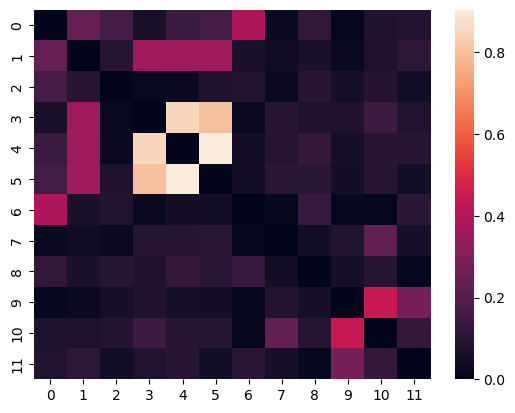

In [190]:
cor=abs(np.corrcoef(df.astype(float),rowvar=False))
np.fill_diagonal(cor,0)
i,j=np.unravel_index(cor.argmax(),cor.shape)
heatmap(cor)
print("Posiciones:")
print (i,j)
print("Variables:",[df.columns[i],df.columns[j]])
print("Correlación Máxima=",cor[i,j])

df=df.drop("G2",axis=1)



EXPLICACION CINCO:Aquí se divide la base en conjunto de entrenamiento (80%) y prueba (20%) con train_test_split.
Se imprime la forma de los conjuntos para confirmar que la partición se hizo correctamente.

Además, se crean términos de interacción entre variables:

Materias reprobadas y faltas = Reprobadas * Faltas.

Escuela e Internet = Escuela_MS * Internet_yes.

Estas interacciones permiten capturar efectos combinados entre variables, mejorando el modelo.

In [305]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df.drop("G3",axis=1),df.G3,train_size = 0.8)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print("Suma de los conjuntos: ", X_train.shape[0]+X_test.shape[0])

X_train.insert(10,"Materias reprobadas y faltas",X_train.Reprobadas*X_train.Faltas)
X_test.insert(10,"Materias reprobadas y faltas",X_test.Reprobadas*X_test.Faltas)
X_train.insert(11,"Escuela e Internet",X_train.Escuela_MS*X_train.Internet_yes)
X_test.insert(11,"Escuela e Internet",X_test.Escuela_MS*X_test.Internet_yes)
X_train.head()
X_test.head()

(312, 10)
(78, 10)
(312,)
(78,)
Suma de los conjuntos:  390


,Edad,Reprobadas,Faltas,G1,Escuela_MS,Sexo_M,Internet_yes,2,3,4,Materias reprobadas y faltas,Escuela e Internet
335,17,0,16,16,False,False,True,False,True,False,0,False
272,18,0,2,11,False,False,False,True,False,False,0,False
389,18,1,0,6,True,False,False,True,False,False,0,False
294,18,0,8,14,False,True,True,False,True,False,0,False
40,16,1,25,7,False,False,True,True,False,False,25,False


EXPLICACION SEIS:En la última parte se entrena y evalúa un modelo de regresión lineal múltiple. Para ello, se utiliza la librería statsmodels, con la clase OLS que permite ajustar un modelo de regresión lineal ordinaria a los datos de entrenamiento. Se añade una constante con sm.add_constant para incluir el intercepto en la ecuación del modelo. Una vez entrenado, se obtiene un resumen con results.summary() que muestra los coeficientes de cada variable, sus valores p, intervalos de confianza y medidas de ajuste como R² y el estadístico F, lo cual permite interpretar el peso y significancia de cada predictor.
Después se generan predicciones sobre el conjunto de prueba con results.predict, y estas se comparan gráficamente contra los valores reales de la calificación final (G3). El gráfico de dispersión permite visualizar qué tan cerca están las predicciones de la línea ideal y=x, lo cual es un indicador de la calidad del modelo. 
Además, se calcula el coeficiente de determinación R² mediante r2_score de scikit-learn, que mide qué porcentaje de la variabilidad de la variable dependiente logra explicar el modelo. 
Finalmente, como análisis adicional, se entrena un modelo de regresión simple entre los valores reales y los estimados para calcular el ángulo de ajuste con respecto a la línea ideal. Esto se hace utilizando la función np.arctan del coeficiente de regresión, expresado en grados, lo que permite medir la inclinación de la relación entre los valores predichos y los observados.

El modelo alcanzó un coeficiente de determinación R² = 0.711, lo que significa que aproximadamente el 71% de la variabilidad en la calificación final (G3) puede explicarse a partir de las variables incluidas en el análisis, esto indica que el modelo tiene una buena predicción, aunque todavía queda cerca de un 29% que no se explica con los factores considerados, posiblemente debido a variables externas que influyen en el desempeño académico.
En cuanto a la validación gráfica, el cálculo del ángulo entre las predicciones y la línea ideal arrojó un valor de 36.2°, el cual se encuentra por debajo de los 45° esto refleja que, si bien las predicciones se aproximan de manera razonable a los valores reales, el modelo tiende a estar menos inclinado que la línea ideal, lo que indica ciertas discrepancias en la capacidad de predicción.

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     51.01
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           4.35e-65
Time:                        21:12:12   Log-Likelihood:                -748.21
No. Observations:                 312   AIC:                             1522.
Df Residuals:                     299   BIC:                             1571.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

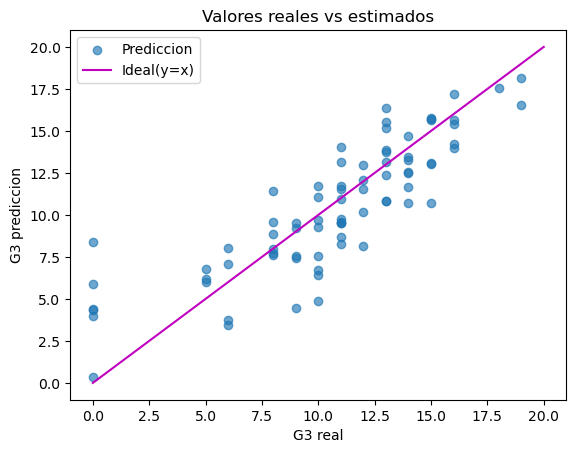

R2: 0.7114072680491872
Angulo: 36.23766026634795


In [308]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
model = sm.OLS(Y_train,sm.add_constant(X_train.astype(float)))
results = model.fit()
print(results.summary())
print(results.pvalues)
print(results.f_pvalue)

yHat=results.predict(sm.add_constant(X_test.astype(float)))
plt.scatter(Y_test,yHat, alpha=0.65, label="Prediccion")
plt.plot([0,20],[0,20],color="m",label="Ideal(y=x)")
plt.xlabel("G3 real")
plt.ylabel("G3 prediccion")
plt.title("Valores reales vs estimados")
plt.legend()
plt.show()

from sklearn.metrics import r2_score
r2 = r2_score(Y_test, yHat)
print("R2:",r2)

model = LinearRegression().fit(Y_test.values.reshape(-1, 1), yHat)
deg = np.arctan(model.coef_[0]) *180/np.pi
print("Angulo:",deg)